import 所需的套件，包括讀檔、分析用的 pandas，以及 tapitas 套件

In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import tapitas

讀檔，觀察欄位資訊

In [4]:
df = pd.read_csv('test_data/demo_0905.csv', index_col=0)
df.head()

node_id             xx            yy  time  cluster_id  chain_id  \
ind                                                                     
0          0  219289.983161  2.672755e+06   124          -1       NaN   
1          1  218977.741200  2.666149e+06   132          -1       NaN   
2          2  203657.935534  2.683383e+06   133          -1       NaN   
3          3  218092.516236  2.668306e+06   133           0       0.0   
4          4  209364.229068  2.667354e+06   136          -1       NaN   

     in_size  out_size  neig_size  
ind                                
0          0        19          0  
1          0        21          3  
2          0         0          0  
3          1        24          7  
4          0         0          0

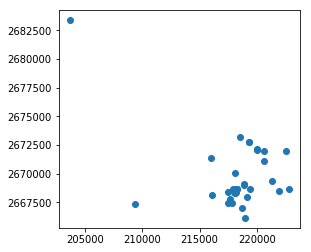

In [6]:
xs = df.xx.tolist()
ys = df.yy.tolist()
pt = [ Point(x,y) for x,y in zip(xs,ys) ]
crs = '+proj=tmerc +lat_0=0 +lon_0=121 +k=0.9999 +x_0=250000 +y_0=0 +ellps=GRS80 +units=m +no_defs'
gdf = gpd.GeoDataFrame(df, geometry=pt, crs=crs)
gdf.plot()

從上述表單可以看到，座標的欄位名稱分別為 xx, yy，時間欄位已轉成天數，標題為 time。

以下開始準備tapitas 所需要的參數，包括:

- pts_setting: 一個 dictionary，需要有三個 key： xcor、ycor、time，分別對應的 value 為在 dataframe 中x、y座標與時間(天數、週數)欄位名字
- s_radius: 搜尋半徑，預設為 500
- T1: 開始有傳染力的天數，預設為 12
- T2: 有傳染力的最後一天， 預設為 27
- resample_time: bootstrap 進行次數，預設為 99
- confidence_level: bootstrap 後計算閾值的信心水準，預設為 '0.80'；可接受設定為 '0.80', '0.85', '0.90', '0.95', '0.99'，注意必須是這幾個 string
- critical_value: 針對已知閾值的資料 (例如之前已計算過)，可在這邊提供閾值數值，並跳過 bootstrap ； 預設為 None，即會執行 bootstrap


In [7]:
pts_setting = {'time':'time'}
s_radius = 5000
T1 = 6
T2 = 23
resample_time=99
confidence_level='0.80'
critical_value=None

產生 tapitas 的 progression graph 物件，並執行分析

In [8]:
PG_graph = tapitas.Point_Diffusion(gdf, pts_setting = pts_setting, s_radius=s_radius, T1=T1, T2=T2, resample_time=resample_time, confidence_level=confidence_level, critical_value=critical_value)


construction of shifting graph - start
construction of shifting graph - stop
making links - start
find links - start
find links - stop
calculate passing possibility - start
calculate passing possibility - stop
calculate propensity - start
calculate propensity - stop
making links - stop
bootstraping - start
critical value is:  0.3397613002589651
bootstraping - stop
detection of subclusters - start
number of subcluster found: 2


將結果物件存出來到 res

In [9]:
res = PG_graph.results

以下示範如何用 res 物件產生 tapitas 演算法的 output 表格

In [10]:
res.get_summary_df()

attribute
clusterno         2.000000
critical_value    0.339761
final_cpair     112.000000
final_slink      40.000000
nodes            36.000000
npair           269.000000
progressno        1.000000
slink           212.000000

In [11]:
res.get_node_df().head()

node_id             xx            yy  time  cluster_id  chain_id  in_size  \
0        0  219289.983161  2.672755e+06   124          -1       NaN        0   
1        1  218977.741200  2.666149e+06   132          -1       NaN        0   
2        2  203657.935534  2.683383e+06   133          -1       NaN        0   
3        3  218092.516236  2.668306e+06   133           0       0.0        1   
4        4  209364.229068  2.667354e+06   136          -1       NaN        0   

   out_size  neig_size  
0        19          0  
1        21          3  
2         0          0  
3        24          7  
4         0          0

In [12]:
res.get_cluster_df().head()

cluster_id  chain_id             xx            yy  cluster_size  \
0           0         0  219311.228138  2.670578e+06            11   
1           1         0  218747.222124  2.668175e+06            13   

   time_median  time_start  time_stop                behaviors  in_count  \
0        138.0         133        143              [appearing]         0   
1        143.0         140        145  [growing, disappearing]         1   

   out_count  
0          1  
1          0

In [13]:
res.get_progress_df().head()

id0  id1  clid  chid  size0  size1             x0             x1  \
0    0    1     1     0     11     13  219311.228138  218747.222124   

             y0            y1   t0   t1        op  no_SL    distance  timelag  
0  2.670578e+06  2.668175e+06  133  145  0.639059     10  2468.08621       12

In [14]:
res.get_final_slinks_df().head()

ooid  ddid  clid  chid     srisk     trisk     crisk    opossi  \
0     0    24     0   0.0  0.997574  0.303864  0.303127  0.991971   
1     1    25     1   0.0  0.437033  0.692362  0.302585  0.419518   
2     0    12     0   0.0  0.473685  0.876032  0.414963  0.999009   
3     1    15     1   0.0  0.216062  0.168737  0.036458  0.293684   
4     0     9     0   0.0  0.022738  0.985402  0.022406  0.870770   

           oxcor         oycor  otime          dxcor         dycor  dtime  \
0  219289.983161  2.672755e+06    124  219289.787023  2.672761e+06    143   
1  218977.741200  2.666149e+06    132  217862.035387  2.667424e+06    144   
2  219289.983161  2.672755e+06    124  220641.266630  2.671978e+06    140   
3  218977.741200  2.666149e+06    132  218149.442355  2.668693e+06    141   
4  219289.983161  2.672755e+06    124  218265.208226  2.668635e+06    138   

      distance  timelag  
0     6.067511       19  
1  1694.576107       12  
2  1558.759506       16  
3  2675.876046        9  
4  4246.040240       14

In [15]:
res.get_final_nlinks_df().head()

n1_id  n2_id  clid  chid   max_cop            n1x           n1y  \
0      3      6     0     0  1.000000  218092.516236  2.668306e+06   
1      3     10     0     0  1.000000  218092.516236  2.668306e+06   
2      3      8     0     0  0.870770  218092.516236  2.668306e+06   
3      3      9     0     0  0.870770  218092.516236  2.668306e+06   
4      3      7     0     0  0.958491  218092.516236  2.668306e+06   

             n2x           n2y  n1t  n2t     distance  timelag  
0  221307.299116  2.669366e+06  133  137  3385.030976        4  
1  216013.290768  2.671408e+06  133  138  3733.690818        5  
2  218265.208226  2.668635e+06  133  138   370.707901        5  
3  218265.208226  2.668635e+06  133  138   370.707901        5  
4  218882.105414  2.669012e+06  133  138  1058.712922        5

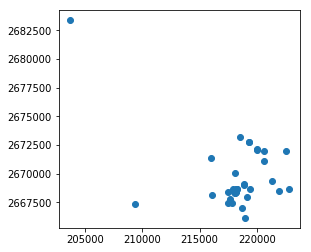

In [16]:
gdf = res.get_node_gdf()
gdf.plot()

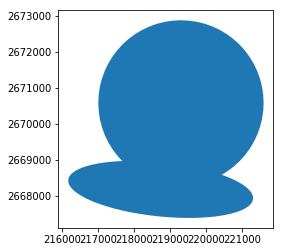

In [17]:
gdf = res.get_cluster_gdf()
gdf.plot()

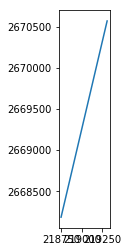

In [18]:
gdf = res.get_progress_gdf()
gdf.plot()

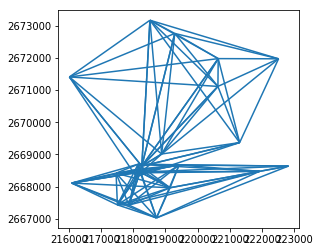

In [19]:
gdf = res.get_final_nlinks_gdf()
gdf.plot()

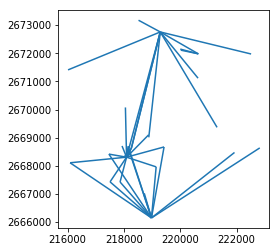

In [20]:
gdf = res.get_final_slinks_gdf()
gdf.plot()

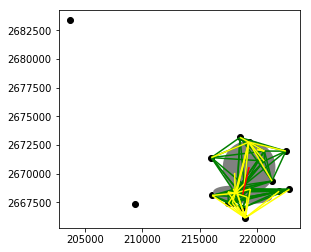

In [21]:
fig,ax = plt.subplots()

gdf = res.get_node_gdf()
gdf.plot(ax=ax, color='k')
gdf = res.get_cluster_gdf()
gdf.plot(ax=ax, color='grey')
gdf = res.get_final_nlinks_gdf()
gdf.plot(ax=ax, color='green')
gdf = res.get_final_slinks_gdf()
gdf.plot(ax=ax, color='yellow')
gdf = res.get_progress_gdf()
gdf.plot(ax=ax, color='red')